In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv('../Dataframes/1-Combined_Data.csv')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate the mean absolute percentage error (MAPE).
    Args:
        y_true: The actual values.
        y_pred: The predicted values.
    Returns:
        The MAPE as a float.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [3]:
def positive_to_1_negative_to_0(array):
    """
    Converts positive values in the array to 1 and negative values to 0.
    
    Parameters:
    array (numpy.ndarray or list): Input array
    
    Returns:
    numpy.ndarray: Array with positive values replaced by 1 and negative values replaced by 0
    """
    import numpy as np
    
    # Convert the input to a NumPy array if it's not already
    array = np.array(array)
    
    # Create a mask for positive values
    positive_mask = array > 0
    
    # Convert positive values to 1 and negative values to 0 using the mask
    array[positive_mask] = 1
    array[~positive_mask] = 0
    
    return array

In [4]:
# Assuming 'df' is your DataFrame containing the data
# Handle potential division by zero and ensure no infinite values are produced
for i in range(1, 8):  # For the last 7 candles
    close_shifted = df['ClosePrice'].shift(i)
    df[f'open_close_ratio_{i}'] = (df['OpenPrice'].shift(i) - close_shifted) / close_shifted.replace(0, np.nan)
    df[f'high_close_ratio_{i}'] = (df['HighPrice'].shift(i) - close_shifted) / close_shifted.replace(0, np.nan)
    df[f'low_close_ratio_{i}'] = (df['LowPrice'].shift(i) - close_shifted) / close_shifted.replace(0, np.nan)

# Calculate the average gain and loss over the last 14 candles
gains = (df['ClosePrice'] - df['OpenPrice']).clip(lower=0).rolling(window=14).mean()
losses = (df['OpenPrice'] - df['ClosePrice']).clip(lower=0).rolling(window=14).mean()
df['avg_gain_loss_ratio'] = gains / losses.replace(0, np.nan)

# Adjust target variable to reflect the change ratio
df['target_change_ratio'] = (df['ClosePrice'] - df['OpenPrice']) / df['ClosePrice'].replace(0, np.nan)

# Drop rows with NaN values that may have been introduced
df = df.dropna()
df.reset_index()

# Define features and target
X = df[['open_close_ratio_1', 'open_close_ratio_2', 'open_close_ratio_3', 'open_close_ratio_4',
        'open_close_ratio_5', 'open_close_ratio_6', 'open_close_ratio_7',
        'high_close_ratio_1', 'high_close_ratio_2', 'high_close_ratio_3', 'high_close_ratio_4',
        'high_close_ratio_5', 'high_close_ratio_6', 'high_close_ratio_7',
        'low_close_ratio_1', 'low_close_ratio_2', 'low_close_ratio_3', 'low_close_ratio_4',
        'low_close_ratio_5', 'low_close_ratio_6', 'low_close_ratio_7',
        'avg_gain_loss_ratio']].replace([np.inf, -np.inf], np.nan).dropna()
y = df['target_change_ratio']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)
y_pred_classified = positive_to_1_negative_to_0(y_pred)
y_test_classified = positive_to_1_negative_to_0(y_test)

diff = y_pred_classified - y_test_classified
correct_mask = (diff == 0)
print(len(diff[correct_mask])/len(diff))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# The model is now trained and can be used for predictions


# Assuming y_test and y_pred are already defined
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

209788
0.5694980694980695
Mean Squared Error: 1.6317801672633198e-05
Mean Absolute Percentage Error (MAPE): 137.04%


In [8]:
# Calculate the potential gain or loss for a given prediction and actual next candle movement.
def calculate_profit(y_pred, open_prices, close_prices):
    """
    Calculate the profit or loss based on predictions and the next candle's open and close prices.
    
    Args:
        y_pred: array of predicted change ratios
        open_prices: array of open prices for the next candle
        close_prices: array of close prices for the next candle
    
    Returns:
        profit: Total profit or loss
    """
    # Predicted action is "buy" if y_pred > 0, "sell" if y_pred <= 0
    actions = np.where(y_pred > 0, "buy", "sell")
    
    # The price change is close - open for the next candle
    price_changes = close_prices - open_prices
    
    # Calculate profit or loss based on action
    profit = np.where(actions == "buy", price_changes, -price_changes)

    # Sum profit across all predictions
    total_profit = np.sum(profit)
    return total_profit

outofbound_mask = y_test.index > len(df)
# Ensure the indices are within bounds
if y_test.index[-1] + 1 < len(df):
    # Extract the open and close prices for the next candle
    next_open_prices = df.iloc[y_test.index + 1]['OpenPrice'].values
    next_close_prices = df.iloc[y_test.index + 1]['ClosePrice'].values
    
    # Calculate the total profit
    total_profit = calculate_profit(y_pred, next_open_prices, next_close_prices)
    print(f'Total Profit: {total_profit}')
else:
    print("Cannot calculate profit - out-of-bounds indices.")


Total Profit: 39477.80999999975


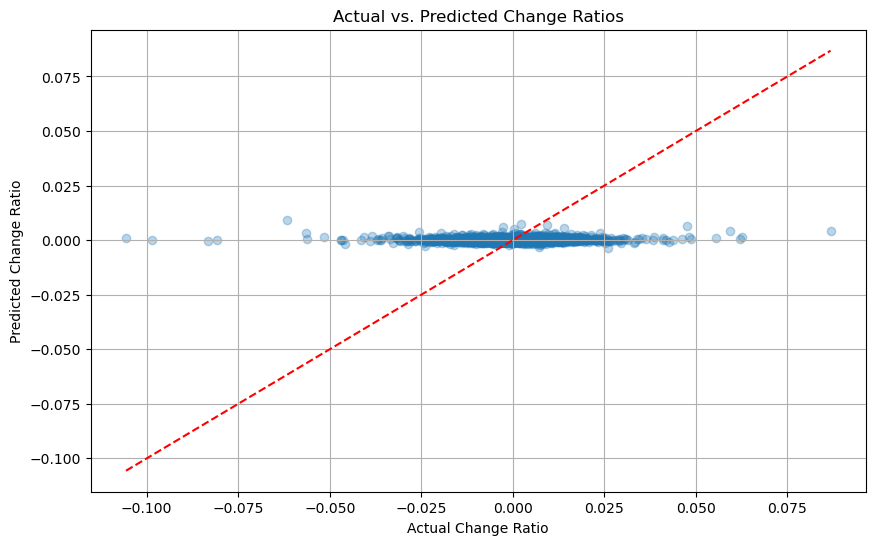

C:\Users\T\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


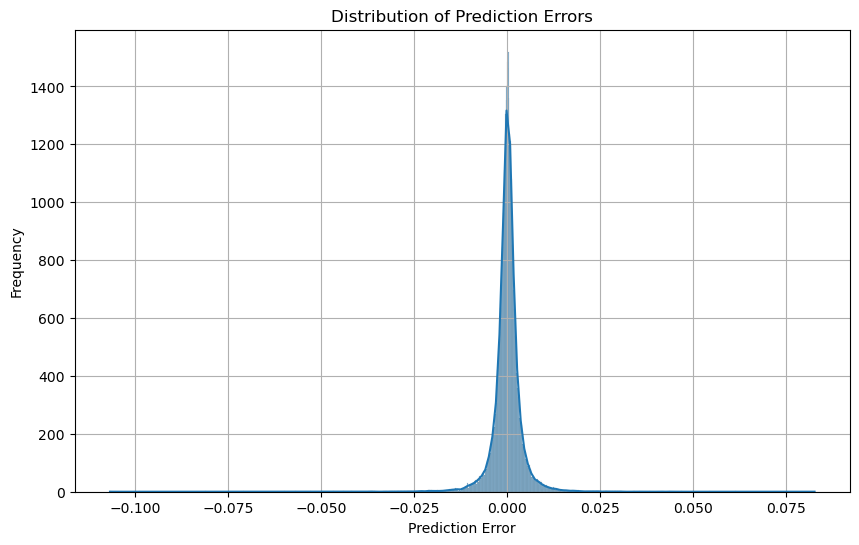

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are already defined from your model predictions

# Actual vs. Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # A reference line for perfect predictions
plt.title('Actual vs. Predicted Change Ratios')
plt.xlabel('Actual Change Ratio')
plt.ylabel('Predicted Change Ratio')
plt.grid(True)
plt.show()

# Plotting the distribution of errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
